# Canny Edge Detector
Algoritma pengolahan citra yang digunakan untuk mendeteksi tepi pada suatu gambar.

Terdapat lima tahapan dari algoritma Canny untuk edge detector, yakni sebagai berikut:


1.   Noise reduction;
2.   Gradient calculation;
3.   Non maximum suppresion;
4.   Double threshold;
5.   Edge Tracking by Hysteresis.




# Grayscale Conversion
Karena Canny edge detector merupakan algoritma image processing yang berbasis pada gambar grayscale, maka input gambar perlu dikonversi kedalam bentuk citra grayscale terlebih dahulu menggunakan operasi dot product.

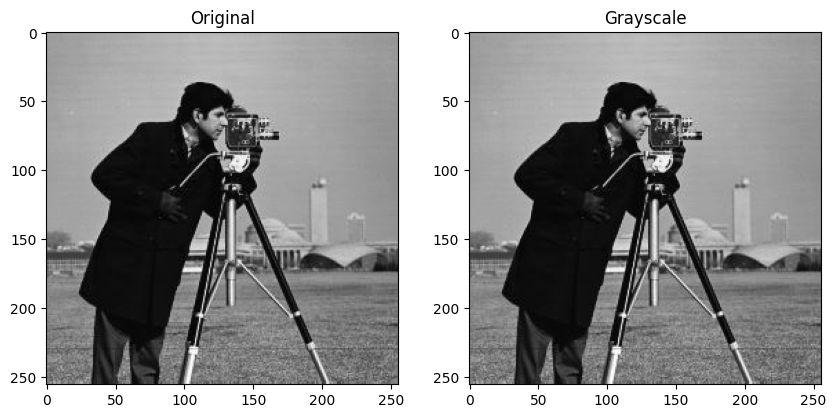

In [85]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

url = "https://www.math.hkust.edu.hk/~masyleung/Teaching/CAS/MATLAB/image/images/cameraman.jpg"
img = io.imread(url)

# Convert the image to grayscale using dot product
img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("on")

axes[1].imshow(img_gray, cmap='gray')
axes[1].set_title("Grayscale")
axes[1].axis("on")

plt.show()

# Noise Reduction

Tahap ini ditujukan untuk menghilangkan noise pada citra menggunakan Gaussian Filter yang dapat terdeteksi sebagai false edge.

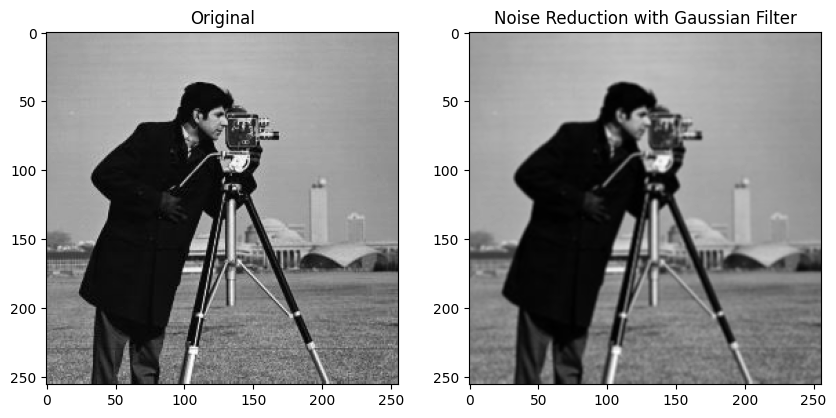

In [86]:
from scipy import ndimage

def gaussian_kernel(size, sigma=1):
    # Hitung nilai setengah dari kernel
    half_size = int(size) // 2
    # Buat matriks koordinat (x, y)
    x, y = np.mgrid[-half_size : half_size + 1, -half_size : half_size + 1]
    # Hitung nilai normalisasi faktor
    normal = 1 / (2.0 * np.pi * sigma ** 2)
    # Hitung nilai kernel Gaussian untuk setiap titik (x, y) pada matriks
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2))) * normal
    return g

# Inisiasi variabel kernel untuk Gaussian filter
kernel_size = 3
kernel_sigma = 1
kernel = gaussian_kernel(kernel_size, sigma=kernel_sigma)

# Terapkan Gaussian filter ke gambar yang sudah di-grayscale
smoothed_img = ndimage.convolve(img_gray, kernel)

# Plot gambar
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Original")
axes[0].axis("on")

axes[1].imshow(smoothed_img, cmap='gray')
axes[1].set_title("Noise Reduction with Gaussian Filter")
axes[1].axis("on")

plt.show()

# Gradient Calculation
Gradient calculation dilakukan dengan filter Sobel, yang bekerja dengan menghitung gradien/perbedaan intensitas pixel pada suatu gambar untuk mengetahui arah dari tepi yang terdapat pada gambar. Hasil akhir dari fungsi sobel_filters adalah matriks intensitas dan arah tepi.

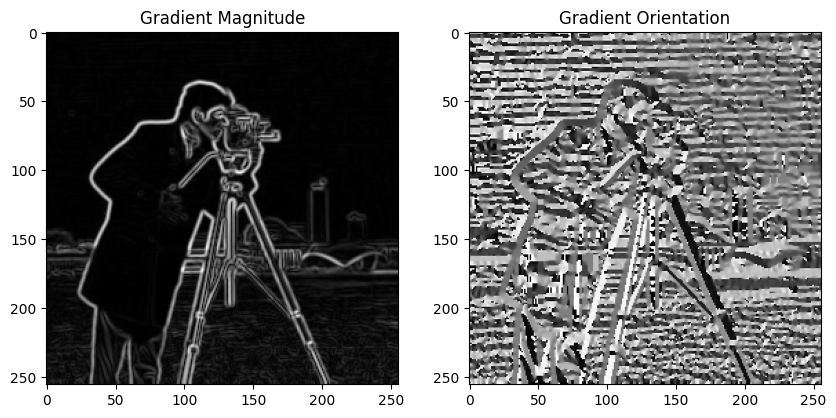

In [87]:
def sobel_filters(img):
    # Inisiasi filter Sobel untuk arah x dan y
    Kx = np.array([[-1, 0, 1],[-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    # Menggunakan modul ndimage, konvulasi gambar asli dengan filter Sobel sebelumnya 
    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)
    
    # Hitung magnitudo gradien (G) dan normalisasi nilai ke dalam rentang 0 - 255
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255

    # Hitung orientasi gradient dengan fungsi arctan2
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

# Terapkan filter Sobel pada result gambar dari tahap Gaussian filter Noise Reduction
(G, theta) = sobel_filters(smoothed_img)

# Plot gambar
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(G, cmap='gray')
axes[0].set_title("Gradient Magnitude")
axes[0].axis("on")

axes[1].imshow(theta, cmap='gray')
axes[1].set_title("Gradient Orientation")
axes[1].axis("on")

plt.show()

# Non-Maximum Suppresion
Umumnya, hasil edge detector memiliki garis tepi yang tipis sehingga diperlukan algoritma non-maximum suppresion untuk menipiskan tepi yang ada. Prinsip algoritma ini adalah dengan mengecek matriks intensitas gradien yang diperoleh pada tahapan gradient calculation sebelumnya dan menemukan pixel dengan nilai maksimum pada arah tepi dengan cara memeriksa nilai magnitudo di sepanjang arah gradien tersebut dan mempertahankan nilai magnitudo pixel yang paling besar.

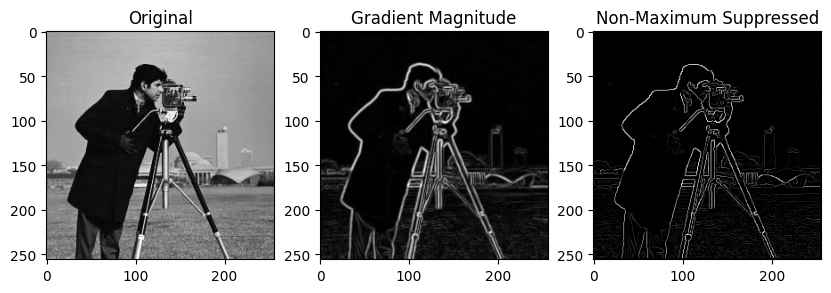

In [88]:
def non_max_suppression(img, D):
    # Hitung ukuran dimensi gambar dan simpan value pada variabel (M x N)
    M, N = img.shape
    # Deklarasi variabel z (int32) sebagai array nol sebesar M x N
    Z = np.zeros((M,N), dtype=np.int32)
    # Hitung sudut gradien dalam satuan derajat
    angle = D * 180. / np.pi
    # Normalisasi sudut agar berada di rentang 0 - 180 derajat
    angle[angle < 0] += 180

    # Menjalankan algoritma non-maximum suppression untuk setiap pixel gambar
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

# Terapkan algoritma non-maximum suppression pada result gambar dari tahapan Gradient calculation menggunakan Sobel filter
suppressed_img = non_max_suppression(G, theta)

# Plot gambar
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("on")

axes[1].imshow(G, cmap='gray')
axes[1].set_title("Gradient Magnitude")
axes[1].axis("on")

axes[2].imshow(suppressed_img, cmap='gray')
axes[2].set_title("Non-Maximum Suppressed")
axes[2].axis("on")

plt.show()

# Double Threshold
Terdapat tiga kategori pixel tepi: strong edge, weak edge dan non-relevant edge. Algoritma ini akan mengklasifikasikan threshold menjadi tiga, yakni:


1.   High threshold: strong pixels
2.   Low threshold: non-relevant pixels
3.   Pixels yang memiliki nilai threshold diantara high dan low ditandai sebagai weak edge untuk selanjutnya diklasifikasikan kembali dengan mekanisme Hysteresis untuk menentukan apakah pixels tersebut merupakan strong edge atau non-relevant edge



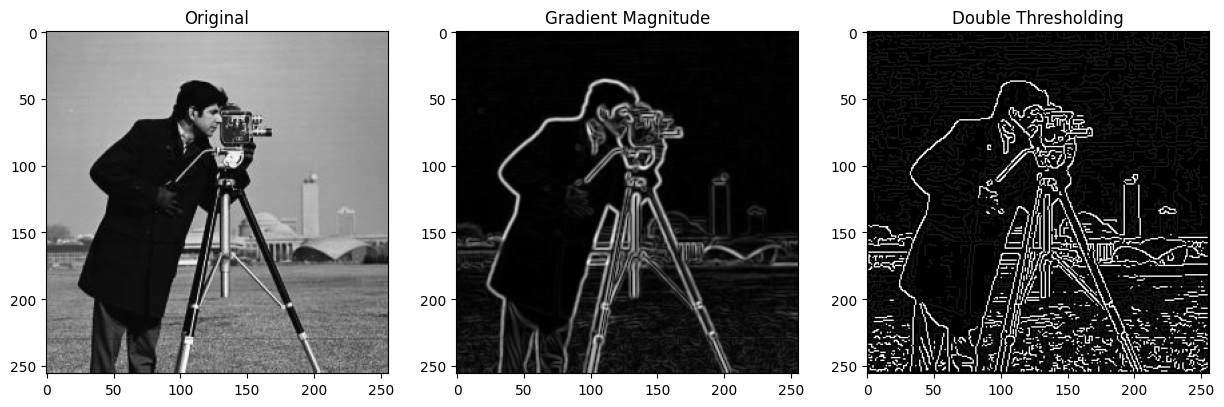

In [89]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    # Hitung nilai low dan high threshold berdasarkan rasio yang ditentukan
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    # Hitung ukuran dimensi gambar dan simpan value pada variabel (M x N)
    M, N = img.shape
    # Deklarasi variabel res (int32) sebagai array nol sebesar M x N
    res = np.zeros((M,N), dtype=np.int32)
    
    # Deklarasi nilai dari variabel threshold untuk weak dan strong
    weak = np.int32(25)
    strong = np.int32(255)
    
    # Mengambil koordinat pixel dengan nilai threshold diatas strong threshold dan dibawah low threshold
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    # Mengambil koordinat pixel dari weak threshold (piksel dengan nilai threshold diantara strong dan low threshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    # Menetapkan nilai piksel pada output
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

# Terapkan algoritma double thresholding pada hasil gambar pada tahapan non-maximum suppression
thresholded_img, weak, strong = threshold(suppressed_img)

# Plot gambar
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("on")

axes[1].imshow(G, cmap='gray')
axes[1].set_title("Gradient Magnitude")
axes[1].axis("on")

axes[2].imshow(thresholded_img, cmap='gray')
axes[2].set_title("Double Thresholding")
axes[2].axis("on")

plt.show()

# Edge Tracking by Hysteresis
Hasil weak edge yang telah ditentukan pada tahap double thresholding selanjutnya akan diklasifikasikan kembali menggunakan teknik edge linking atau edge tracking menggunakan mekanisme Hysteresis. Mekanisme ini memiliki prinsip sebagai berikut:

1.   Jika disekitar pixel weak edge terdapat strong edge yang berdekatan, maka pixel ini akan dihubungkan dengan pixel strong edge dan diklasifikasikan menjadi strong edge
2.   Jika disekitar pixel weak edge tidak terdapat strong edge yang berdekatan, maka pixel ini tidak dianggap sebagai tepi melainkan diklasifikasikan menjadi non-relevant edge

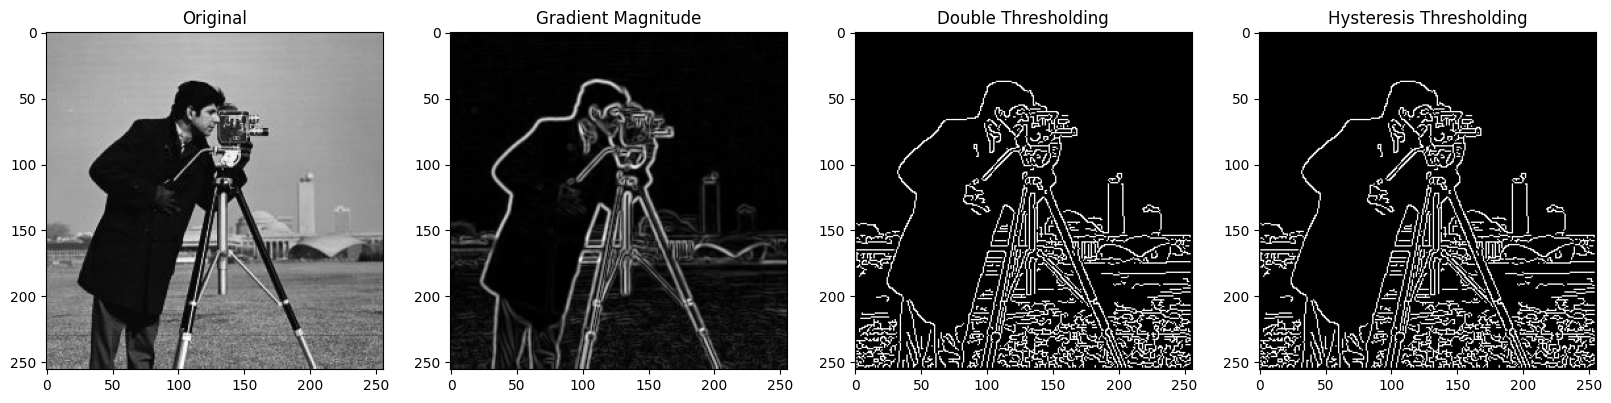

In [90]:
def hysteresis(img, weak, strong=255):
    # Hitung ukuran dimensi gambar dan simpan value pada variabel (M x N)
    M, N = img.shape  

    # Menjalankan algoritma hystersis thresholding pada citra 
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

# Terapkan algoritma hysteresis thresholding pada hasil yang diperoleh pada tahapan double thresholding
hysteresis_img = hysteresis(thresholded_img, weak, strong)

# Plot gambar
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("on")

axes[1].imshow(G, cmap='gray')
axes[1].set_title("Gradient Magnitude")
axes[1].axis("on")

axes[2].imshow(thresholded_img, cmap='gray')
axes[2].set_title("Double Thresholding")
axes[2].axis("on")

axes[3].imshow(hysteresis_img, cmap='gray')
axes[3].set_title("Hysteresis Thresholding")
axes[3].axis("on")

plt.show()